# **Import Libraries**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import re
import requests
from io import StringIO
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tabulate import tabulate

# **Ensure Using GPU**

In [3]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Running on {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("Running on CPU")

Running on Tesla T4


# **Load Dataset**

In [4]:
def load_data(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    english_sentences = []
    arabic_sentences = []

    for line in lines:
        parts = line.strip().split('\t')
        if len(parts) >= 2:
            english, arabic = parts[0], parts[1]
            english_sentences.append(english)
            arabic_sentences.append(arabic)
    return english_sentences, arabic_sentences

filepath = "/kaggle/input/arabic-data/ara_.txt" # find data p
english_sentences, arabic_sentences = load_data(filepath)

# **Visualize Data**

╒═════╤═══════════╤══════════╕
│   # │ English   │ Arabic   │
╞═════╪═══════════╪══════════╡
│   1 │ Hi.       │ مرحبًا.   │
├─────┼───────────┼──────────┤
│   2 │ Run!      │ اركض!    │
├─────┼───────────┼──────────┤
│   3 │ Help!     │ النجدة!  │
├─────┼───────────┼──────────┤
│   4 │ Jump!     │ اقفز!    │
├─────┼───────────┼──────────┤
│   5 │ Stop!     │ قف!      │
├─────┼───────────┼──────────┤
│   6 │ Go on.    │ داوم.    │
├─────┼───────────┼──────────┤
│   7 │ Go on.    │ استمر.   │
├─────┼───────────┼──────────┤
│   8 │ Hello!    │ مرحباً.   │
├─────┼───────────┼──────────┤
│   9 │ Hurry!    │ تعجّل!    │
├─────┼───────────┼──────────┤
│  10 │ Hurry!    │ استعجل!  │
╘═════╧═══════════╧══════════╛


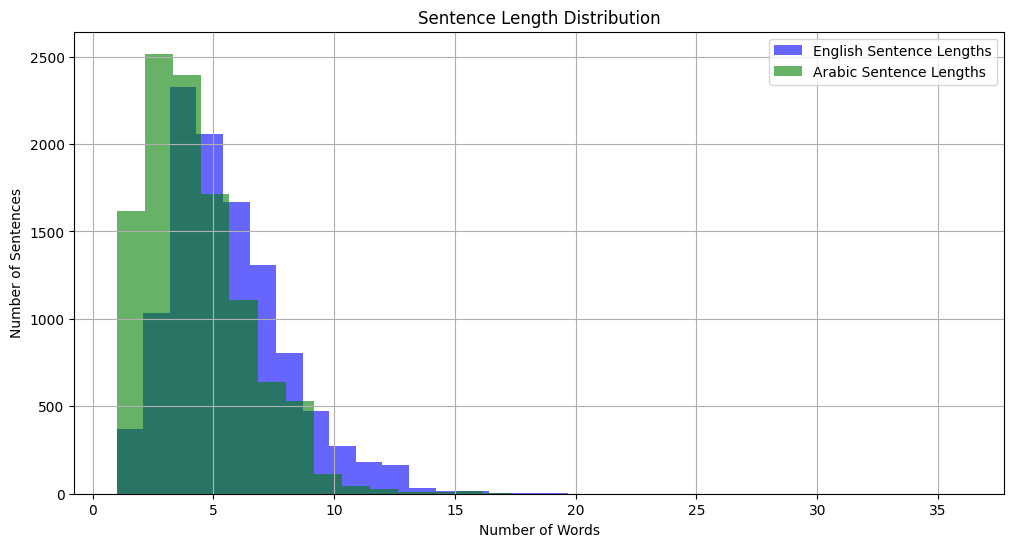

In [5]:
def visualize_pairs(english_sentences, arabic_sentences, num_samples=10):
    data = []
    for i in range(min(num_samples, len(english_sentences))):
        data.append([i+1, english_sentences[i], arabic_sentences[i]])
    
    print(tabulate(data, headers=["#", "English", "Arabic"], tablefmt="fancy_grid"))

def visualize_lengths(english_sentences, arabic_sentences):
    en_lengths = [len(sentence.split()) for sentence in english_sentences]
    ar_lengths = [len(sentence.split()) for sentence in arabic_sentences]

    plt.figure(figsize=(12, 6))

    plt.hist(en_lengths, bins=30, alpha=0.6, label='English Sentence Lengths', color='blue')
    plt.hist(ar_lengths, bins=30, alpha=0.6, label='Arabic Sentence Lengths', color='green')

    plt.title('Sentence Length Distribution')
    plt.xlabel('Number of Words')
    plt.ylabel('Number of Sentences')
    plt.legend()
    plt.grid(True)
    plt.show()


visualize_pairs(english_sentences, arabic_sentences)
visualize_lengths(english_sentences, arabic_sentences)

# **Data preprocessing**

In [6]:
def preprocess_data(sentences, lang):
    processed_sentences = []
    for sentence in sentences:
        if lang == 'en':
            sentence = sentence.lower()
            sentence = re.sub(r'[^\w\s]', '', sentence)
        else:
            sentence = re.sub(r'[^\w\s]', '', sentence)  # Arabic

        tokens = sentence.strip().split()
        processed_sentences.append(['<sos>'] + tokens + ['<eos>'])
    return processed_sentences


preprocessed_en = preprocess_data(english_sentences, 'en')
preprocessed_ar = preprocess_data(arabic_sentences, 'ar')

for i in range(10):
    print(f"English [{i+1}]:", preprocessed_en[i])
    print(f"Arabic  [{i+1}]:", preprocessed_ar[i])
    print("-" * 70)

English [1]: ['<sos>', 'hi', '<eos>']
Arabic  [1]: ['<sos>', 'مرحبا', '<eos>']
----------------------------------------------------------------------
English [2]: ['<sos>', 'run', '<eos>']
Arabic  [2]: ['<sos>', 'اركض', '<eos>']
----------------------------------------------------------------------
English [3]: ['<sos>', 'help', '<eos>']
Arabic  [3]: ['<sos>', 'النجدة', '<eos>']
----------------------------------------------------------------------
English [4]: ['<sos>', 'jump', '<eos>']
Arabic  [4]: ['<sos>', 'اقفز', '<eos>']
----------------------------------------------------------------------
English [5]: ['<sos>', 'stop', '<eos>']
Arabic  [5]: ['<sos>', 'قف', '<eos>']
----------------------------------------------------------------------
English [6]: ['<sos>', 'go', 'on', '<eos>']
Arabic  [6]: ['<sos>', 'داوم', '<eos>']
----------------------------------------------------------------------
English [7]: ['<sos>', 'go', 'on', '<eos>']
Arabic  [7]: ['<sos>', 'استمر', '<eos>']
-------

# **Build Vocabulary**

In [7]:
def build_vocab(sentences, max_size=None):
    word_counts = {}
    for sentence in sentences:
        for word in sentence:
            word_counts[word] = word_counts.get(word, 0) + 1

    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    vocab = {'<pad>': 0, '<unk>': 1}
    if max_size:
        sorted_words = sorted_words[:max_size - 2]

    for word, _ in sorted_words:
        vocab[word] = len(vocab)

    return vocab

en_vocab = build_vocab(preprocessed_en, 5000)
ar_vocab = build_vocab(preprocessed_ar, 5000)

print("Sample English vocab:", list(en_vocab.items())[:10])
print("#" * 136)
print("Sample Arabic vocab:", list(ar_vocab.items())[:10])

Sample English vocab: [('<pad>', 0), ('<unk>', 1), ('<sos>', 2), ('<eos>', 3), ('i', 4), ('you', 5), ('the', 6), ('to', 7), ('a', 8), ('is', 9)]
########################################################################################################################################
Sample Arabic vocab: [('<pad>', 0), ('<unk>', 1), ('<sos>', 2), ('<eos>', 3), ('من', 4), ('أن', 5), ('توم', 6), ('في', 7), ('لا', 8), ('هل', 9)]


# **Convert sentences to indices**

In [8]:
def sentences_to_indices(sentences, vocab):
    indices = []
    for sentence in sentences:
        indices.append([vocab.get(word, vocab['<unk>']) for word in sentence])
    return indices

# Convert preprocessed sentences to indices
en_indices = sentences_to_indices(preprocessed_en, en_vocab)
ar_indices = sentences_to_indices(preprocessed_ar, ar_vocab)

for i in range(10):
    print(f"English [{i+1}]: {preprocessed_en[i]}")
    print(f"Indices  [{i+1}]: {en_indices[i]}")
    print(f"Arabic  [{i+1}]: {preprocessed_ar[i]}")
    print(f"Indices  [{i+1}]: {ar_indices[i]}")
    print("-" * 80)


English [1]: ['<sos>', 'hi', '<eos>']
Indices  [1]: [2, 806, 3]
Arabic  [1]: ['<sos>', 'مرحبا', '<eos>']
Indices  [1]: [2, 686, 3]
--------------------------------------------------------------------------------
English [2]: ['<sos>', 'run', '<eos>']
Indices  [2]: [2, 341, 3]
Arabic  [2]: ['<sos>', 'اركض', '<eos>']
Indices  [2]: [2, 2650, 3]
--------------------------------------------------------------------------------
English [3]: ['<sos>', 'help', '<eos>']
Indices  [3]: [2, 65, 3]
Arabic  [3]: ['<sos>', 'النجدة', '<eos>']
Indices  [3]: [2, 1060, 3]
--------------------------------------------------------------------------------
English [4]: ['<sos>', 'jump', '<eos>']
Indices  [4]: [2, 681, 3]
Arabic  [4]: ['<sos>', 'اقفز', '<eos>']
Indices  [4]: [2, 2651, 3]
--------------------------------------------------------------------------------
English [5]: ['<sos>', 'stop', '<eos>']
Indices  [5]: [2, 164, 3]
Arabic  [5]: ['<sos>', 'قف', '<eos>']
Indices  [5]: [2, 1945, 3]
---------------

# **Use custom data into a PyTorch DataLoader**

In [9]:
class TranslationDataset(Dataset):
    def __init__(self, src_data, tgt_data): # Stores source & target indexed sentences
        self.src_data = src_data # list of padded token indices (English)
        self.tgt_data = tgt_data # list of padded token indices (Arabic)
    
    def __len__(self): # Returns total number of sentence pairs
        return len(self.src_data)
    
    def __getitem__(self, idx): # Returns one source-target pair as tensors
        return torch.tensor(self.src_data[idx]), torch.tensor(self.tgt_data[idx])

# data loader
def collate_DataLoader(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=0)
    return src_batch, tgt_batch

# **Transformer model components**

In [10]:
class AttentionHead(nn.Module):
    def __init__(self, model_dim, num_heads):
        super(AttentionHead, self).__init__()
        assert model_dim % num_heads == 0, "model_dim must be divisible by num_heads"

        self.model_dim = model_dim
        self.num_heads = num_heads
        self.head_dim = model_dim // num_heads

        self.query_layer = nn.Linear(model_dim, model_dim)
        self.key_layer = nn.Linear(model_dim, model_dim)
        self.value_layer = nn.Linear(model_dim, model_dim)
        self.output_layer = nn.Linear(model_dim, model_dim)

    def compute_attention(self, query, key, value, mask=None):
        # Compute attention scores (dot product of query and key)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # Check if mask is provided
        if mask is not None:
            # Expand mask to match the dimensions of attention scores (batch_size, num_heads, seq_len, seq_len)
            mask = mask.unsqueeze(1).repeat(1, query.size(1), 1, 1)

            # Apply the mask to the scores (masked_fill expects the mask to have the same shape as scores)
            scores = scores.masked_fill(mask == 0, -1e9)

        # Compute the attention probabilities
        attention_probs = torch.softmax(scores, dim=-1)

        # Multiply the attention probabilities with the value tensor
        output = torch.matmul(attention_probs, value)

        return output

    def split_heads(self, tensor):
        batch_size, seq_len, model_dim = tensor.size()
        return tensor.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

    def merge_heads(self, tensor):
        batch_size, num_heads, seq_len, head_dim = tensor.size()
        return tensor.transpose(1, 2).contiguous().view(batch_size, seq_len, self.model_dim)

    def forward(self, query, key, value, mask=None):
        query = self.split_heads(self.query_layer(query))
        key = self.split_heads(self.key_layer(key))
        value = self.split_heads(self.value_layer(value))

        attention_output = self.compute_attention(query, key, value, mask)
        output = self.output_layer(self.merge_heads(attention_output))
        return output

In [11]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, model_dim, hidden_dim):
        super(FeedForwardNetwork, self).__init__()
        self.fc1 = nn.Linear(model_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, model_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [12]:
class PositionalEmbedding(nn.Module):
    def __init__(self, model_dim, max_len):
        super(PositionalEmbedding, self).__init__()

        pos_enc = torch.zeros(max_len, model_dim)
        positions = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2).float() * -(math.log(10000.0) / model_dim))

        pos_enc[:, 0::2] = torch.sin(positions * div_term)
        pos_enc[:, 1::2] = torch.cos(positions * div_term)

        self.register_buffer('pos_enc', pos_enc.unsqueeze(0))

    def forward(self, x):
        return x + self.pos_enc[:, :x.size(1)]

In [13]:
class EncoderBlock(nn.Module):
    def __init__(self, model_dim, num_heads, hidden_dim, dropout_rate):
        super(EncoderBlock, self).__init__()
        self.self_attention = AttentionHead(model_dim, num_heads)
        self.feed_forward = FeedForwardNetwork(model_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(model_dim)
        self.norm2 = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, encoder_input, src_mask):
        attention_out = self.self_attention(encoder_input, encoder_input, encoder_input, src_mask)
        encoder_input = self.norm1(encoder_input + self.dropout(attention_out))
        ff_out = self.feed_forward(encoder_input)
        encoder_input = self.norm2(encoder_input + self.dropout(ff_out))
        return encoder_input

In [14]:
class DecoderBlock(nn.Module):
    def __init__(self, model_dim, num_heads, hidden_dim, dropout_rate):
        super(DecoderBlock, self).__init__()
        self.self_attention = AttentionHead(model_dim, num_heads)
        self.cross_attention = AttentionHead(model_dim, num_heads)
        self.feed_forward = FeedForwardNetwork(model_dim, hidden_dim)
        self.norm1 = nn.LayerNorm(model_dim)
        self.norm2 = nn.LayerNorm(model_dim)
        self.norm3 = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, decoder_input, encoder_output, src_mask, tgt_mask):
        attention_out = self.self_attention(decoder_input, decoder_input, decoder_input, tgt_mask)
        decoder_input = self.norm1(decoder_input + self.dropout(attention_out))
        cross_attention_out = self.cross_attention(decoder_input, encoder_output, encoder_output, src_mask)
        decoder_input = self.norm2(decoder_input + self.dropout(cross_attention_out))
        ff_out = self.feed_forward(decoder_input)
        decoder_input = self.norm3(decoder_input + self.dropout(ff_out))
        return decoder_input

In [15]:
class TransformerModel(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, model_dim, num_heads, num_layers, hidden_dim, max_len, dropout_rate):
        super(TransformerModel, self).__init__()
        self.encoder_embedding = nn.Embedding(input_vocab_size, model_dim)
        self.decoder_embedding = nn.Embedding(output_vocab_size, model_dim)
        self.positional_embedding = PositionalEmbedding(model_dim, max_len)

        self.encoder_blocks = nn.ModuleList([EncoderBlock(model_dim, num_heads, hidden_dim, dropout_rate) for _ in range(num_layers)])
        self.decoder_blocks = nn.ModuleList([DecoderBlock(model_dim, num_heads, hidden_dim, dropout_rate) for _ in range(num_layers)])

        self.fc_out = nn.Linear(model_dim, output_vocab_size)
        self.dropout = nn.Dropout(dropout_rate)

    def generate_mask(self, source, target):
        # Ensure masks are created on the same device as the inputs
        src_mask = (source != 0).unsqueeze(1).to(source.device)
        tgt_mask = (target != 0).unsqueeze(1).to(target.device)

        seq_len = target.size(1)
        no_peak_mask = (1 - torch.triu(torch.ones(1, seq_len, seq_len), diagonal=1)).bool().to(target.device)
        tgt_mask = tgt_mask & no_peak_mask

        return src_mask, tgt_mask

    def forward(self, src_input, tgt_input):
        src_mask, tgt_mask = self.generate_mask(src_input, tgt_input)
        src_embedded = self.dropout(self.positional_embedding(self.encoder_embedding(src_input)))
        tgt_embedded = self.dropout(self.positional_embedding(self.decoder_embedding(tgt_input)))

        encoder_output = src_embedded
        for encoder_block in self.encoder_blocks:
            encoder_output = encoder_block(encoder_output, src_mask)

        decoder_output = tgt_embedded
        for decoder_block in self.decoder_blocks:
            decoder_output = decoder_block(decoder_output, encoder_output, src_mask, tgt_mask)

        output = self.fc_out(decoder_output)
        return output

# **Function to load and prepare data**

In [16]:
def prepare_data(batch_size=64):
    print("Loading and preprocessing data...")

    try:
        dataset = TranslationDataset(en_indices, ar_indices)
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            collate_fn=collate_DataLoader
        )

        return dataloader, len(en_vocab), len(ar_vocab), en_vocab, ar_vocab

    except Exception as e:
        print(f"Error loading data: {e}")
        return None, 5000, 5000, None, None

# **Evaluation function**

In [17]:
def evaluate(model, dataloader, loss_fn, num_batches=5):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, (src, tgt) in enumerate(dataloader):
            if i >= num_batches:
                break
            
            src, tgt = src.to(device), tgt.to(device)
            
            # Forward pass
            predictions = model(src, tgt[:, :-1])
            
            # Compute loss
            loss = loss_fn(predictions.contiguous().view(-1, predictions.size(-1)), 
                          tgt[:, 1:].contiguous().view(-1))
            
            total_loss += loss.item()
    
    return total_loss / min(num_batches, len(dataloader))

# **Set hyperparameters**

In [18]:
model_dim = 256  # Reduced from 512 to fit in memory
num_heads = 8
num_layers = 4   # Reduced from 6 to fit in memory
hidden_dim = 1024 # Reduced from 2048 to fit in memory
max_len = 300     # Increased for real sentences
dropout_rate = 0.1
batch_size = 32   # Reduced batch size
num_epochs = 75

In [19]:
# Prepare data
dataloader, input_vocab_size, output_vocab_size, src_vocab, tgt_vocab = prepare_data(batch_size)

Loading and preprocessing data...


# **Initialize the model with data**

In [ ]:
transformer_model = TransformerModel(
    input_vocab_size, output_vocab_size, model_dim, num_heads, 
    num_layers, hidden_dim, max_len, dropout_rate
).to(device)

# Set loss function and optimizer
loss_fn = nn.CrossEntropyLoss(ignore_index=0).to(device)
optimizer = optim.Adam(transformer_model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Initialize lists to store losses
train_losses = []
val_losses = []

# Training loop
print("Starting training...")
transformer_model.train()
for epoch in range(num_epochs):
    total_loss = 0
    num_batches = 0
    
    for src_batch, tgt_batch in dataloader:
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)
        
        optimizer.zero_grad()

        # Forward pass
        predictions = transformer_model(src_batch, tgt_batch[:, :-1])

        # Compute loss
        loss = loss_fn(predictions.contiguous().view(-1, output_vocab_size), 
                      tgt_batch[:, 1:].contiguous().view(-1))

        # Backpropagation
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(transformer_model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    scheduler.step(avg_loss)
    
    # Evaluate on a few batches
    val_loss = evaluate(transformer_model, dataloader, loss_fn)
    
    # Store losses
    train_losses.append(avg_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.6f}, Validation Loss: {val_loss:.6f}")
    
    # Save model checkpoint
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': transformer_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, f'transformer_checkpoint_epoch_{epoch+1}.pt')

Starting training...
Epoch 1/75, Training Loss: 5.851560, Validation Loss: 5.256752
Epoch 2/75, Training Loss: 4.890580, Validation Loss: 4.434268
Epoch 3/75, Training Loss: 4.325719, Validation Loss: 3.911093
Epoch 4/75, Training Loss: 3.872898, Validation Loss: 3.672397
Epoch 5/75, Training Loss: 3.484476, Validation Loss: 3.260552
Epoch 6/75, Training Loss: 3.143302, Validation Loss: 2.839780
Epoch 7/75, Training Loss: 2.829513, Validation Loss: 2.523578
Epoch 8/75, Training Loss: 2.539342, Validation Loss: 2.173657
Epoch 9/75, Training Loss: 2.267460, Validation Loss: 1.947842
Epoch 10/75, Training Loss: 2.011342, Validation Loss: 1.705035
Epoch 11/75, Training Loss: 1.779655, Validation Loss: 1.454932
Epoch 12/75, Training Loss: 1.566253, Validation Loss: 1.337117
Epoch 13/75, Training Loss: 1.375620, Validation Loss: 1.224959
Epoch 14/75, Training Loss: 1.207512, Validation Loss: 1.039200
Epoch 15/75, Training Loss: 1.051322, Validation Loss: 0.893406
Epoch 16/75, Training Loss: 

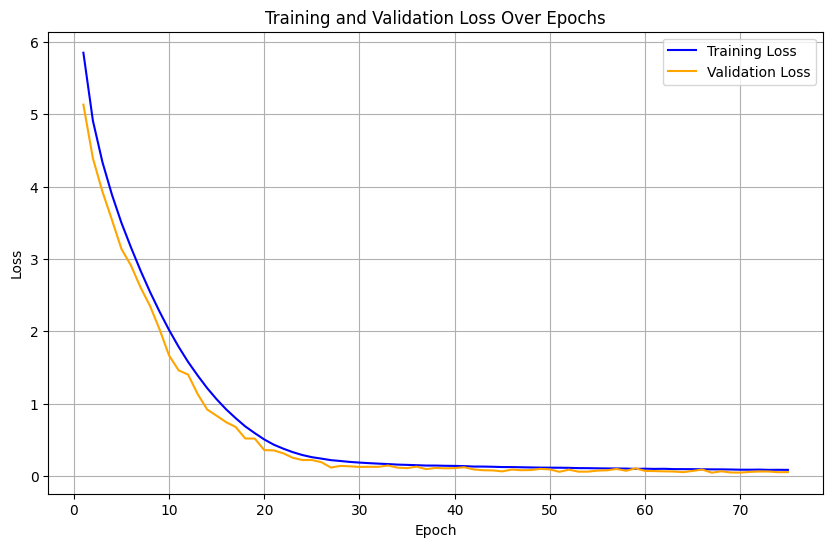

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')  # Save the plot to a file

# **Save the final model**

In [21]:
torch.save({
    'model_state_dict': transformer_model.state_dict(),
    'src_vocab': src_vocab,
    'tgt_vocab': tgt_vocab,
    'model_config': {
        'input_vocab_size': input_vocab_size,
        'output_vocab_size': output_vocab_size,
        'model_dim': model_dim,
        'num_heads': num_heads,
        'num_layers': num_layers,
        'hidden_dim': hidden_dim,
        'max_len': max_len,
        'dropout_rate': dropout_rate
    }
}, 'transformer_ar_en_final.pt')

In [22]:
checkpoint = torch.load("transformer_ar_en_final.pt", map_location=device)
config = checkpoint['model_config']
model = TransformerModel(
    config['input_vocab_size'], config['output_vocab_size'],
    config['model_dim'], config['num_heads'], config['num_layers'],
    config['hidden_dim'], config['max_len'], config['dropout_rate']
).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
src_vocab = checkpoint['src_vocab']
tgt_vocab = checkpoint['tgt_vocab']
test_dataloader, _, _, _, _ = prepare_data(batch_size=32)

Loading and preprocessing data...


/tmp/ipykernel_31/974794265.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("transformer_ar_en_final.pt", map_location=device)


In [23]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# === Translation and BLEU scoring ===
def translate_sentence(sentence, src_vocab, tgt_vocab, model, max_len=100):
    model.eval()
    sentence = re.sub(r'[^\w\s]', '', sentence.lower())  # Clean punctuation
    tokens = ['<sos>'] + sentence.strip().split() + ['<eos>']  # Word-level tokens
    input_ids = [src_vocab.get(tok, src_vocab['<unk>']) for tok in tokens]
    src_tensor = torch.tensor(input_ids).unsqueeze(0).to(device)

    tgt_ids = [tgt_vocab['<sos>']]
    for _ in range(max_len):
        tgt_tensor = torch.tensor(tgt_ids).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(src_tensor, tgt_tensor)
        next_token = torch.argmax(output[0, -1, :]).item()
        tgt_ids.append(next_token)
        if next_token == tgt_vocab['<eos>']:
            break

    idx2word = {i: w for w, i in tgt_vocab.items()}
    return ' '.join([
        idx2word.get(i, '') 
        for i in tgt_ids[1:] 
        if i not in [0, tgt_vocab['<eos>'], tgt_vocab['<unk>']]
    ])

def compute_bleu(model, dataloader, src_vocab, tgt_vocab, num_samples=100):
    model.eval()
    total_score = 0
    count = 0
    idx2src = {i: w for w, i in src_vocab.items()}
    idx2tgt = {i: w for w, i in tgt_vocab.items()}
    smoother = SmoothingFunction().method1

    for src_batch, tgt_batch in dataloader:
        src_batch, tgt_batch = src_batch.to(device), tgt_batch.to(device)
        for src, tgt in zip(src_batch, tgt_batch):
            src = [i for i in src.tolist() if i != 0]
            tgt = [i for i in tgt.tolist() if i not in [0, tgt_vocab['<sos>'], tgt_vocab['<eos>'], tgt_vocab['<unk>']]]

            src_sentence = ' '.join([idx2src[i] for i in src if i not in [src_vocab['<unk>']]])
            ref = [' '.join([idx2tgt[i] for i in tgt])]
            pred = translate_sentence(src_sentence, src_vocab, tgt_vocab, model)

            score = sentence_bleu([ref[0].split()], pred.split(), smoothing_function=smoother)
            total_score += score
            count += 1
            if count >= num_samples:
                return total_score / count
    return total_score / count

In [24]:
def print_random_english_examples(model, src_vocab, tgt_vocab):
    examples = [
        "What time is it?",
        "I love programming.",
        "This book is very interesting.",
        "Can you help me, please?",
        "The weather is nice today.",
        "Hurry!, Tom",
        "Stop,I'm sad",
        "I am happy to see you again.",
        "Tom is waiting for you at home.",
        "Please come in and have a seat.",
        "Let's go to the park this afternoon.",
        "She loves to dance at parties.",
        "He is a doctor and very kind.",
        "I want to read more books this year.",
        "The birds sing beautifully in the morning.",
        "We need help to solve this problem.",
        "You should try to be more creative."
    ]
    print("Random English Sentences with Translations:")
    for sentence in examples:
        translation = translate_sentence(sentence, src_vocab, tgt_vocab, model)
        print(f"\nExample Translation:\nEN: {sentence}\nAR: {translation}")


In [26]:
# === Run and test BLEU after training ===
def run_test():
    print("Testing BLEU score on 1000 samples...")
    bleu = compute_bleu(model, test_dataloader, src_vocab, tgt_vocab, num_samples=1000)
    print(f"\nAverage BLEU score: {bleu:.4f}")

    print_random_english_examples(model, src_vocab, tgt_vocab)

# Uncomment this to run test directly
run_test()

Testing BLEU score on 1000 samples...

Average BLEU score: 0.3102
Random English Sentences with Translations:

Example Translation:
EN: What time is it?
AR: ما الساعة الآن

Example Translation:
EN: I love programming.
AR: أنا أحب مادة العلوم

Example Translation:
EN: This book is very interesting.
AR: هذا الكتاب ممتع

Example Translation:
EN: Can you help me, please?
AR: أيمكنك مساعدتي في فضلك

Example Translation:
EN: The weather is nice today.
AR: الجو حار اليوم

Example Translation:
EN: Hurry!, Tom
AR: استعجل توم

Example Translation:
EN: Stop,I'm sad
AR: ما زالت لديك

Example Translation:
EN: I am happy to see you again.
AR: أنا سعيد لرؤيتك مجددا

Example Translation:
EN: Tom is waiting for you at home.
AR: توم ينتظر في المنزل

Example Translation:
EN: Please come in and have a seat.
AR: تفضل

Example Translation:
EN: Let's go to the park this afternoon.
AR: لنذهب إلى هذه بعد الظهر

Example Translation:
EN: She loves to dance at parties.
AR: إنها تحب الرقص

Example Translation:
EN: